<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Neural%20ML/Loss_wrapped_neural_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Модели
import torch
import torch.nn as nn

# Метрики качества
from time import time

from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchmetrics
from torchmetrics import R2Score

!pip install torcheval
from torcheval.metrics.functional import r2_score

#!pip install onnx
#!pip install hiddenlayer
#import hiddenlayer as hl
!pip install torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

# Обработка датасета
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Удобства
from tqdm import tqdm

# Шедуллер
from torch.optim.lr_scheduler import ReduceLROnPlateau

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Фиксация сида:

In [3]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Перенос модели на GPU:

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Подготовка данных

## Загрузка данных и скриптов

Загружаем датасет с GitHub:

In [14]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-05-31 10:22:57--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-05-31 10:22:57--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  15.63M  8.26MB/s    in 1.9s    

2023-05-31 10:23:00 (8.26 MB/s) - ‘/tmp/data.zip’ saved [16393815]



In [15]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


## Скейлинг

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [16]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

mode_number = 4

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разбиение подвыборок на X и Y данные:

In [17]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


In [18]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [19]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12,1.652589e+06,2.179432e+06,3.360062e-14,2.047043e-29,1.705975e-11,2.492992e+06,2.138282e+06,3.363194e-14,3.150402e-29,2.224337e-11,3.350131e+06,1.953502e+06,3.366659e-14,4.638795e-29,2.730320e-11
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12,8.950608e+07,8.741688e+04,1.780460e-15,1.034411e-22,3.956188e-12,1.634791e+08,6.489439e+04,1.773305e-15,2.534792e-22,4.171862e-12,2.560639e+08,5.143171e+04,1.759506e-15,4.970636e-22,4.369109e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11,8.167046e+06,6.037550e+07,1.029027e-14,2.094931e-30,1.748103e-11,1.256789e+07,5.489475e+07,1.036000e-14,3.569687e-30,2.206222e-11,1.732588e+07,4.940941e+07,1.039743e-14,5.487195e-30,2.605582e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12,1.127357e+08,3.688876e+04,2.603435e-15,9.736272e-26,3.848615e-12,2.067481e+08,3.532490e+04,2.583663e-15,1.850441e-25,4.200149e-12,3.232575e+08,3.457247e+04,2.556074e-15,2.924626e-25,4.656986e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13,6.131970e+06,1.006085e+09,2.964966e-14,1.132194e-32,5.494210e-12,9.438750e+06,8.997463e+08,2.985198e-14,1.962020e-32,1.288137e-11,1.301669e+07,8.200638e+08,2.995975e-14,2.979387e-32,1.521141e-11


Выполняем логарифмирование и скейлинг:

In [20]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 4
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train=x_train, y_train=y_train)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [21]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.014167,-0.006174,0.025109,0.013023,0.008054,-0.013916,-0.006343,0.024551,0.002942,0.007557,-0.014963,-0.006363,0.024660,-0.004944,0.007016,-0.007708,-0.006983,0.021198,-0.008800
std,0.988296,0.961995,0.980944,0.988541,0.984973,0.989626,0.963986,0.980410,0.990055,0.982179,0.990671,0.964596,0.980489,0.990604,0.972298,0.991183,0.973177,0.982377,0.995477,0.968027
min,-2.210503,-2.607106,-2.922469,-2.305750,-3.902680,-2.127390,-2.584861,-2.962526,-2.293187,-4.179475,-2.081414,-2.565005,-2.962160,-2.289673,-4.170642,-2.053933,-2.643954,-2.904239,-2.465779,-4.017885
25%,-0.764214,-0.696085,-0.714197,-0.681071,-0.555324,-0.764181,-0.706019,-0.699185,-0.682143,-0.422503,-0.769533,-0.703914,-0.700720,-0.686954,-0.489975,-0.775452,-0.694660,-0.682452,-0.697956,-0.514381
50%,-0.023415,-0.068124,-0.015231,0.061847,0.294927,-0.050238,-0.053054,-0.015728,0.057023,0.173135,-0.075644,-0.052964,-0.015262,0.053236,0.093081,-0.088919,-0.047806,-0.002947,0.056189,0.043985
75%,0.712678,0.682357,0.743511,0.773055,0.726739,0.691099,0.700989,0.737272,0.761989,0.654429,0.713913,0.700747,0.735649,0.751653,0.632641,0.720316,0.716392,0.735474,0.738864,0.655614
max,2.345348,2.479744,2.259412,2.881269,2.064679,2.397605,2.476387,2.267635,2.878661,2.222553,2.403320,2.453312,2.266518,2.853652,2.301370,2.239074,3.003916,2.242780,2.784347,2.308940


## Визуализация распределения нормированных параметров

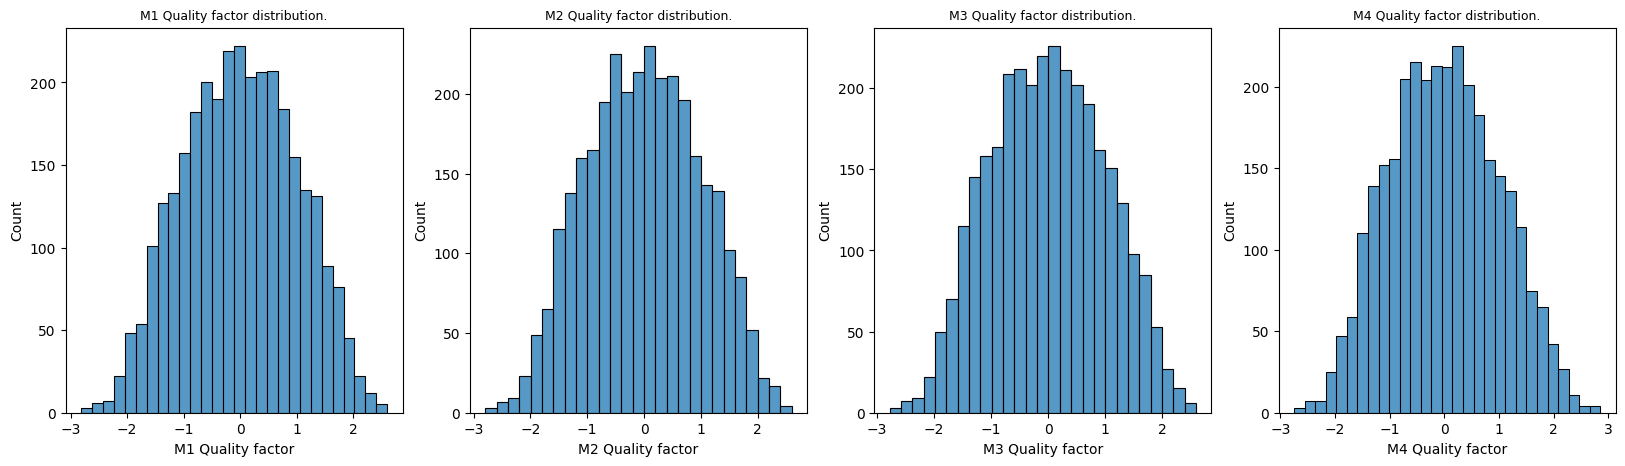

In [22]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Quality factor',
                  log_scale=False, font_size=0.25)

## Формирование подвыборок

Определение подвыборок и даталоадеров:

In [23]:
from dataset_preprocessing_torch import CustomDataset

trainset = CustomDataset(x_train, y_train)
valset = CustomDataset(x_val, y_val)
testset = CustomDataset(x_test, y_test)

batch_size = 64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [24]:
print(len(train_loader))

50


# Модель Branched Fully Connected + Loss weight wrapper

### Функции для обучения

Функция для вычисления метрик по каждому параметру:

In [ ]:
def train_branched_wrapped(wrapper, branch_num, criterion, optimizer, scheduler, plot_par, num_epochs=10, tag="cifar10"):
    pp = ProgressPlotter()

    for epoch in range(num_epochs):
        y_log = torch.empty(size=[0, num_pars_y]).to(device)
        output_log = torch.empty(size=[0, num_pars_y]).to(device)

        wrapper.train()
        for batch in train_loader:     # кусок данных для обучения
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            loss, vars = wrapper(input=x, target=y)

            with torch.no_grad():
                output_1, output_2 = wrapper.model(x) # загружаем данные в модель и получаем выходы
            
            # output = (output_1 * 0.5).add(output_2 * 0.5) - раскомментить, если хотите поиграться с идеей слияния короткой и длинной ветвей
            output = output_2 # берем в качестве выхода модели выход длинной ветви

            y_log = torch.cat((y_log, y), dim=0)
            output_log = torch.cat((output_log, output), dim=0)

            loss.backward()
            optimizer.step()

        # Берем все объекты из тренировочного даталоадера и считаем метрики
        output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)

        # Logging
        if epoch % 10 ==0:
            pp.add_scalar('MSE_train', output_dict[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict[plot_par][1].cpu().detach().numpy())

        wrapper.eval()
        output_dict_val = calculate_val_metrics_branched(wrapper.model, val_loader, criterion)

        scheduler.step(output_dict_val[plot_par][0])

        if epoch % 10 ==0:
            pp.add_scalar('MSE_val', output_dict_val[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val[plot_par][1].cpu().detach().numpy())

        if epoch % 10 ==0:
            #pp.display([['loss_train', 'loss_val']])
            pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
    return pp, vars

### Работа с коэффициентами в ошибке

Класс, с помощью которого:
*   обучается модель
*   обучаются коэффициенты в функции ошибки



In [29]:
class LossWrapper(nn.Module):
    def __init__(self, model, branch_num):
        # branch_num - количество выходов модели
        super(LossWrapper, self).__init__()
        self.model = model
        self.branch_num = branch_num

        # Определим дисперсии каждого выхода как обучаемый параметр
        self.vars = nn.Parameter(torch.zeros(size=(branch_num,)))
    
    def forward(self, input, target):
        # Через это место будет обучаться сама модель
        output = self.model(input)

        precision = []
        for index in range(0, self.branch_num):
            precision.append(torch.exp(-self.vars[index]))

        # В двух строках ниже фигурирует одна и та же переменная 'target'.
        # Это связано с тем, что в данной модели (Branched MLP) два разных слагаемых
        # в лосс-функции предсказывают одно и то же.
        loss = torch.zeros(size=(target.shape[0],)).to(device)
        for index in range(0, self.branch_num):
            loss += torch.sum(precision[index] * (target - output[index]) * (target - output[index]) + self.vars[index], -1)

        loss = torch.mean(loss)

        return loss, self.vars.data.tolist()

### Построение модели

In [31]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

In [32]:
class BranchedFCNetwork(nn.Module):
    def __init__(self, neck_features):
        super().__init__()
        self.network_general = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=300, bias=False),
            nn.BatchNorm1d(num_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=int(neck_features / 2), bias=False),
            nn.BatchNorm1d(num_features=int(neck_features / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(neck_features / 2), out_features=neck_features, bias=True),
            nn.ReLU()
        )

        # Короткая ветвь
        self.network_short = nn.Linear(in_features=neck_features, out_features=num_pars_y, bias=True)

        # Хранилище длинных ветвей
        self.network_branches = nn.ModuleList()

        # Длинные ветви
        for branch_index in range(0, num_pars_y):
            self.network_branches.append(BranchBlock(in_features=neck_features))
    


    def forward(self, x):
        batch_size_x = x.shape[0]

        # Проходим по общим слоям
        x = self.network_general(x)

        # Прохожим по короткой ветви
        out_1 = self.network_short(x)

        # Проходим по длинным ветвям
        out_2 = torch.empty(size=[batch_size_x, 0]).to(device)
        for branch_index in range(0, num_pars_y):
            out_temp = self.network_branches[branch_index](x)
            out_2 = torch.cat((out_2, out_temp), dim=1)
        
        return out_1, out_2
    
    # Инициализация весов
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()


# Блок длинной ветви
class BranchBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1, bias=False)
        )
    
    def forward(self, x):
        out = self.network(x)
        return out

### Процесс обучения модели

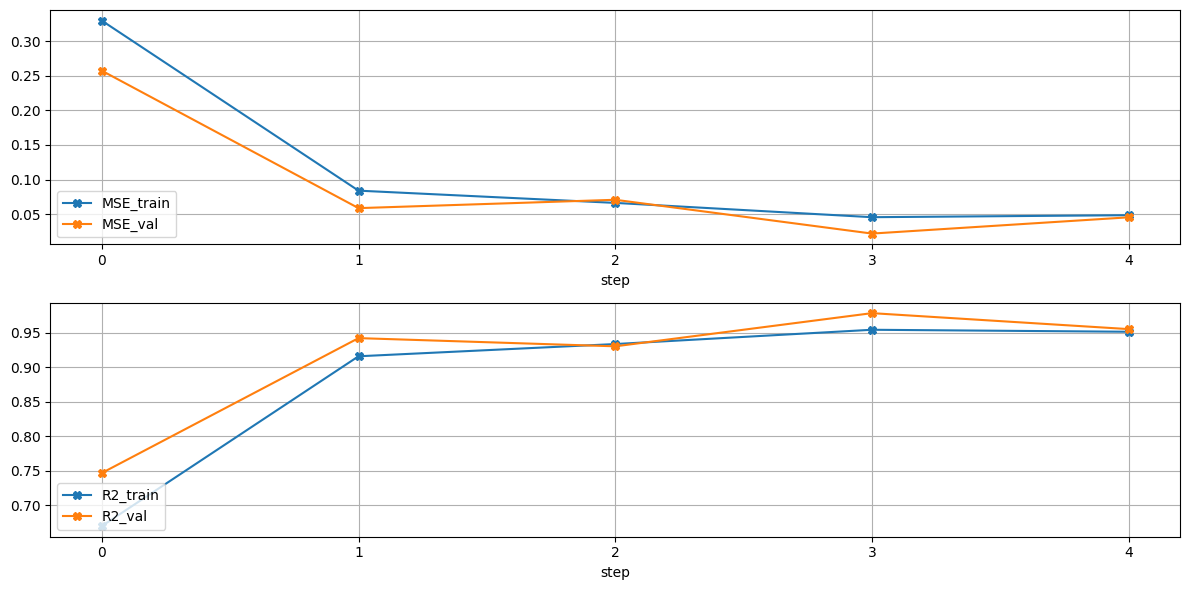

Epoch 00042: reducing learning rate of group 0 to 1.0000e-06.


In [35]:
from neural_ml import train_branched_wrapped

branch_num = 2

model_branched = BranchedFCNetwork(neck_features=1000).to(device)
wrapper = LossWrapper(model=model_branched, branch_num=branch_num).to(device)
optimizer = torch.optim.Adam(wrapper.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
criterion = nn.MSELoss()

pp, vars = train_branched_wrapped(wrapper,
                                  train_loader, val_loader,
                                  criterion, optimizer, scheduler, 
                                  num_epochs=50, param_names=None,
                                  plot_param='M1 Quality factor')

In [36]:
print(vars)

[-0.14605392515659332, -0.1405290812253952]


Проверка на тестовом датасете:

In [38]:
from neural_ml import calculate_val_metrics_branched

output_dict_test_branched = calculate_val_metrics_branched(wrapper.model, test_loader, param_names=None)

# Для приятного вида
for name in output_dict_test_branched.keys():
    for index in range(0, len(output_dict_test_branched[name])):
        output_dict_test_branched[name][index] = output_dict_test_branched[name][index].item()
print(output_dict_test_branched)

{'M1 Eigenfrequency (Hz)': [0.005390877369791269, 0.9944750666618347], 'M1 Quality factor': [0.02674625813961029, 0.9710692167282104], 'M1 Effective mass (kg)': [0.008581317029893398, 0.991072952747345], 'M1 TED (W)': [0.015494214370846748, 0.9841283559799194], 'M1 Noise (kg^2/s^3)': [0.031082216650247574, 0.967929482460022], 'M2 Eigenfrequency (Hz)': [0.005859340541064739, 0.9940111041069031], 'M2 Quality factor': [0.026363462209701538, 0.9716010093688965], 'M2 Effective mass (kg)': [0.009395754896104336, 0.9902150630950928], 'M2 TED (W)': [0.016792170703411102, 0.9828513264656067], 'M2 Noise (kg^2/s^3)': [0.034145403653383255, 0.9645681977272034], 'M3 Eigenfrequency (Hz)': [0.005279872566461563, 0.9946147203445435], 'M3 Quality factor': [0.028775397688150406, 0.9690420031547546], 'M3 Effective mass (kg)': [0.009122769348323345, 0.9905008673667908], 'M3 TED (W)': [0.015042459592223167, 0.9846552014350891], 'M3 Noise (kg^2/s^3)': [0.03522661328315735, 0.9626995325088501], 'M4 Eigenfreq

# Дополнительное тестирование

Пробуем дать модели на вход тестовые данные: либо параметры реально существующего устройства, либо параметры устройств, сгенерированных в FEM, но лежащие на границах распределений параметров.

In [40]:
gate_U = 0
gate_D = 300

x_real = pd.DataFrame([[70, 200, 100, 30, 1, gate_D, gate_U, 0],
                       [30, 170, 60, 80, 1, gate_D, gate_U, 0],
                       [30, 300, 100, 30, 1, gate_D, gate_U, 0],
                       [150, 300, 100, 30, 1, gate_D, gate_U, 0]]) # это параметры реально изготовленного устройства
x_real.columns = x_train.columns

y_real_ = pd.DataFrame(np.ones(shape=(4, 20)))
y_real_.columns = y_train.columns
y_real_.iloc[0, 0] = 2.166e6 # zero tension
y_real_.iloc[1, 0] = 6.3e6 # zero tension
y_real_.iloc[2, 0] = 11.6e6 # non-zero tension
y_real_.iloc[3, 0] = 1.66e6 # non-zero tension

x_real = s.transform_real_x(x_real)

x_real_torch = torch.tensor(x_real.iloc[:, :].values, dtype=torch.float32).to(device)

# Подаем реальные данные на вход модели
with torch.no_grad():
    _, y_real_pred = wrapper.model(x_real_torch)
y_real_pred = pd.DataFrame(y_real_pred.detach().cpu().numpy())

x_real, y_real_pred = s.reverse_transform(x_real, y_real_pred, concat_required=False)
y_real_pred = pd.DataFrame(y_real_pred)
y_real_pred.columns = y_train.columns

real_pred = pd.concat([x_real, y_real_pred], axis=1)
real_pred.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,70.0,200.0,100.0,30.0,1.0,300.0,0.0,0.0,2263168.00,7.346932e+05,...,6745458.0,7.531494e+05,3.121818e-15,2.330212e-28,3.452765e-12,9476674.0,9.674470e+05,3.031217e-15,3.574090e-28,5.603629e-12
1,30.0,170.0,60.0,80.0,1.0,300.0,0.0,0.0,6931290.50,1.491568e+06,...,22163812.0,9.313867e+05,6.313096e-16,1.262359e-27,3.752707e-12,29778852.0,2.054784e+06,1.081777e-15,3.822503e-28,5.167820e-12
2,30.0,300.0,100.0,30.0,1.0,300.0,0.0,0.0,6141538.00,7.006151e+06,...,21381096.0,6.358913e+06,1.904761e-15,3.940372e-28,5.641954e-12,32553812.0,4.722769e+06,1.699477e-15,7.956508e-28,6.188181e-12
3,150.0,300.0,100.0,30.0,1.0,300.0,0.0,0.0,940802.25,4.917483e+05,...,3408873.5,5.381604e+05,9.691246e-15,1.341498e-28,4.993064e-12,4357639.0,7.694069e+05,9.794624e-15,1.285245e-28,8.171630e-12
